In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
X_train = np.loadtxt("../data/samsung_HAR/samsung_train.txt")
y_train = np.loadtxt("../data/samsung_HAR/samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("../data/samsung_HAR/samsung_test.txt")
y_test = np.loadtxt("../data/samsung_HAR/samsung_test_labels.txt").astype(int)

In [3]:
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

In [4]:
X = np.hstack((X_train.T, X_test.T))
y = np.concatenate((y_train,y_test))
X=X.T

In [6]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [7]:
n_classes = np.unique(y).size

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit(X)

In [25]:
pca = PCA(0.9, random_state=RANDOM_STATE) 
X_pca = pca.fit_transform(X)
print('We need %d components to explain 90%% of variance' 
      % pca.n_components_)

We need 36 components to explain 90% of variance


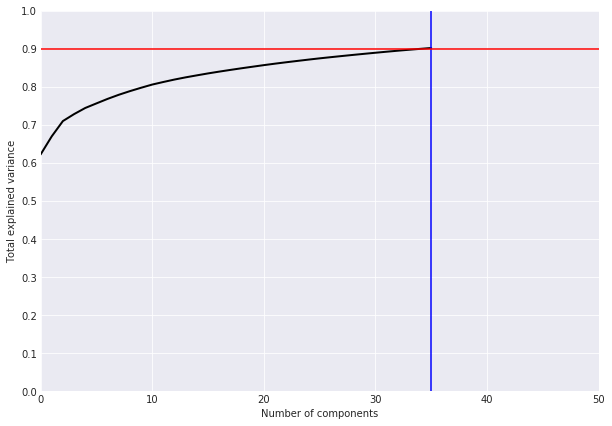

In [26]:
plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 50)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(35, c='b')
plt.axhline(0.9, c='r')
plt.show();

In [27]:
for i, component in enumerate(pca.components_):
    print("{} component: {}% of initial variance".format(i + 1, 
          round(100 * pca.explained_variance_ratio_[i], 2)))
    

1 component: 62.23% of initial variance
2 component: 4.77% of initial variance
3 component: 4.02% of initial variance
4 component: 1.82% of initial variance
5 component: 1.61% of initial variance
6 component: 1.2% of initial variance
7 component: 1.19% of initial variance
8 component: 1.08% of initial variance
9 component: 0.96% of initial variance
10 component: 0.89% of initial variance
11 component: 0.84% of initial variance
12 component: 0.68% of initial variance
13 component: 0.64% of initial variance
14 component: 0.58% of initial variance
15 component: 0.52% of initial variance
16 component: 0.51% of initial variance
17 component: 0.47% of initial variance
18 component: 0.45% of initial variance
19 component: 0.43% of initial variance
20 component: 0.41% of initial variance
21 component: 0.41% of initial variance
22 component: 0.39% of initial variance
23 component: 0.37% of initial variance
24 component: 0.35% of initial variance
25 component: 0.35% of initial variance
26 compon

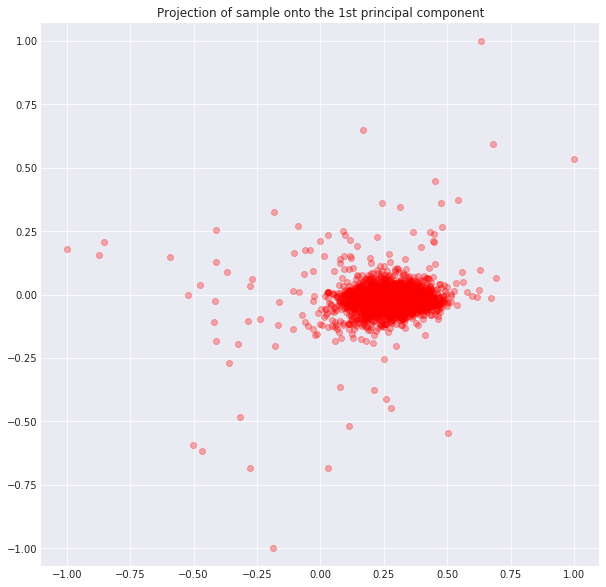

In [28]:
X_new = pca.inverse_transform(X_pca)
plt.figure(figsize=(10,10))
plt.plot(X[:, 0], X[:, 1], 'or', alpha=0.3)
plt.plot(X_new[:, 0], X_new[:, 1], 'or', alpha=0.8)
plt.axis('equal')
plt.title('Projection of sample onto the 1st principal component')
plt.show()

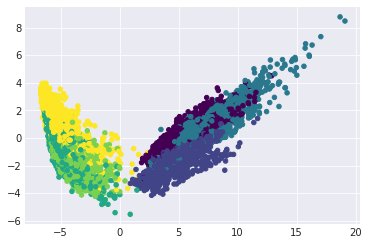

In [29]:
plt.scatter(X_pca[:, 0], X_pca[:, 1],c=y, s=20, cmap='viridis');

In [30]:
kmeans = KMeans(n_clusters=n_classes, n_init = 100, random_state=RANDOM_STATE)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=100, n_jobs=None, precompute_distances='auto',
       random_state=17, tol=0.0001, verbose=0)

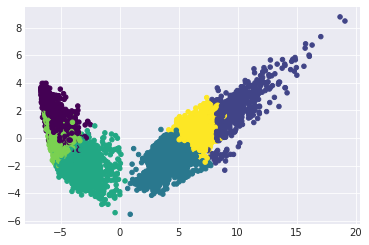

In [34]:

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, s=20,  cmap='viridis');

In [35]:
tab = pd.crosstab(y, kmeans.labels_, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,0,150,704,0,0,868,1722
подъем вверх по лестнице,0,81,1166,0,0,297,1544
спуск по лестнице,0,455,187,0,0,764,1406
сидение,49,0,3,469,1256,0,1777
стояние,0,0,0,673,1233,0,1906
лежание,1761,0,12,171,0,0,1944
все,1810,686,2072,1313,2489,1929,10299


In [37]:
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

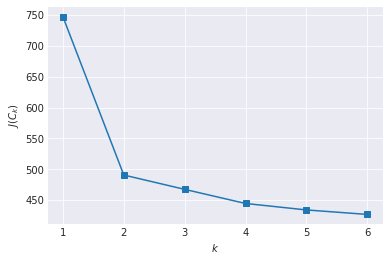

In [38]:
plt.plot(range(1, n_classes + 1), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

In [39]:
ag = AgglomerativeClustering(n_clusters=n_classes, 
                             linkage='ward').fit(X_pca)

In [43]:
metrics.adjusted_rand_score(y, ag.labels_)

0.5079060462877689

In [45]:
X_train_scaled = scaler.fit(X_train)
X_test_scaled = scaler.fit(X_test)

In [46]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [50]:
best_svc = GridSearchCV(svc, cv=3, param_grid=svc_params).fit(X_train, y_train)

E:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Anaconda\lib\site-packages\sklearn\svm\bas